In [ ]:
import os
import numpy as np
import random
from PIL import Image
from tqdm.auto import tqdm
import pandas as pd
import ttach as tta

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score   

### Setting

wandb 사용해서 실험 결과 관리하였습니다.

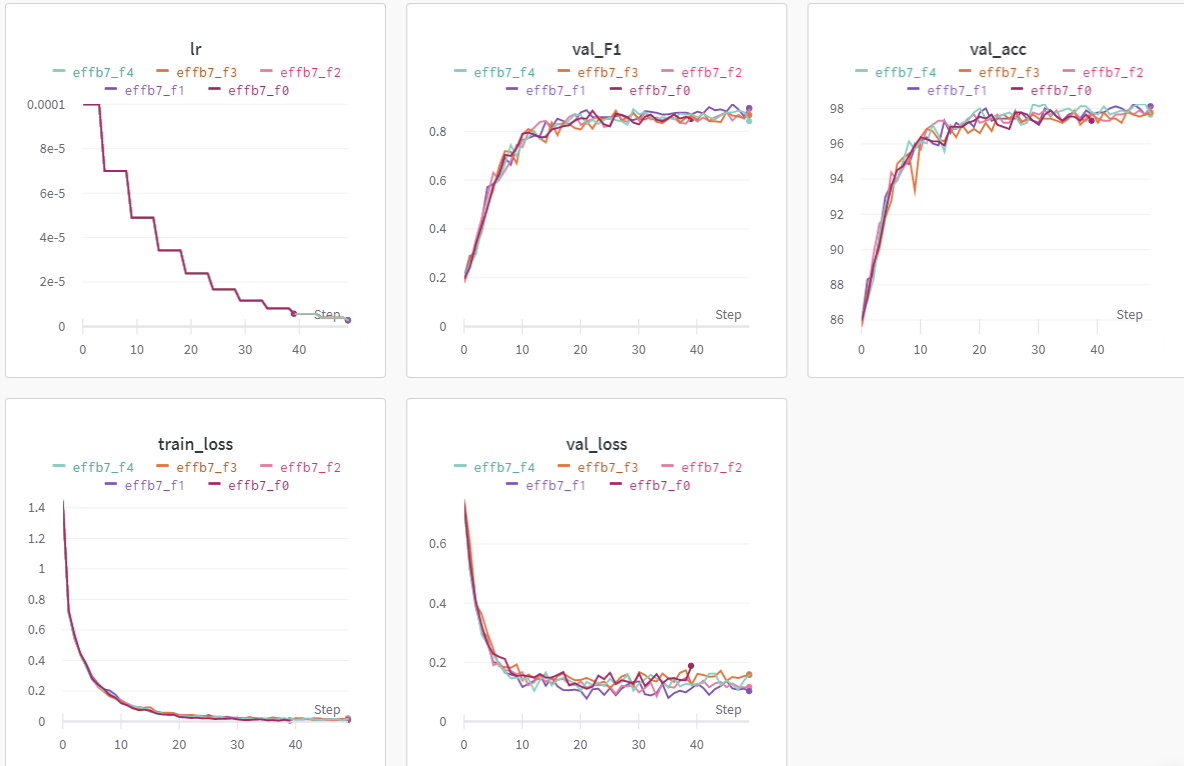

In [ ]:
import wandb

# wandb.init(project = "dacon_anormaly", entity = , config = {}, name = 'effb7_f0')

In [ ]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(42)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
config = AttrDict()

In [ ]:
config.data_path = 'open/train'
config.test_path = 'open/test'
config.n_epoch = 50
config.learning_rate = 1e-4
config.b1 = 0.9
config.b2 = 0.999
# input (512, 384)
config.augmentation = transforms.Compose([
                        transforms.Resize((512, 512)),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees = (-90, 90)),
                        transforms.RandomGrayscale(p=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                      ])

config.val_augmentation = transforms.Compose([
                        transforms.Resize((512, 512)),
                        transforms.ToTensor(),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees = (-30, 30)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                      ])

config.test_augmentation = transforms.Compose([
                        transforms.Resize((512, 512)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
                      ])


config.batch_size = 10
config.denormalize = lambda x: x * torch.tensor([[[0.229]], [[0.224]], [[0.225]]])+torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
config.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
wandb.config.batch_size = config.batch_size
wandb.config.learning_rate = config.learning_rate
wandb.config.b1 = config.b1
wandb.config.b2 = config.b2
wandb.config.loss = 'CrossEntropy'
wandb.config.model = 'Eff_b7'
wandb.config.fold_num = 0

In [ ]:
df = pd.read_csv('open/train_df.csv')

In [ ]:
df.head(10)

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good
5,5,10005.png,wood,good,wood-good
6,6,10006.png,capsule,good,capsule-good
7,7,10007.png,screw,good,screw-good
8,8,10008.png,cable,bent_wire,cable-bent_wire
9,9,10009.png,transistor,good,transistor-good


In [ ]:
label_list = sorted(np.unique(df['label']))

label_to_num = {label_list[i] : i for i in range(len(label_list))}
num_to_label = {i : label_list[i] for i in range(len(label_list))}
print(f"label nunique : {len(label_list)}")

label nunique : 88


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      4277 non-null   int64 
 1   file_name  4277 non-null   object
 2   class      4277 non-null   object
 3   state      4277 non-null   object
 4   label      4277 non-null   object
dtypes: int64(1), object(4)
memory usage: 167.2+ KB


<AxesSubplot:>

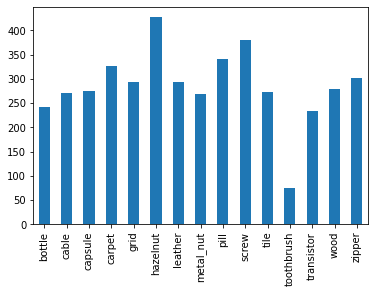

In [ ]:
df['class'].value_counts().sort_index().plot(kind = 'bar')
# df['label'].value_counts().sort_index().plot(kind = 'bar', figsize = (30, 60))

In [ ]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
df_train_list = []
df_val_list = []

for train_idx, val_idx in split.split(df, df["label"]):
    df_strat_train = df.loc[train_idx]
    df_strat_val = df.loc[val_idx]
    df_train_list.append(df_strat_train.reset_index())
    df_val_list.append(df_strat_val.reset_index())

In [ ]:
class custom_dataset(Dataset):
    def __init__(self, df, data_path, transform, is_test = False):
        self.df = df
        self.transform = transform
        self.data_path = data_path
        self.file_name = self.df['file_name']
        self.is_test = is_test
        if self.is_test == False:
            self.cls = self.df['class']
            self.label = self.df['label']
            self.state = self.df['state']
        

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.file_name[idx])
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        if self.is_test == False:
            label = label_to_num[self.label[idx]]
            return img, label
        else:
            return img
    
    def __len__(self):
        return len(self.df)

In [ ]:
df_train_list[0]['label']

0                    hazelnut-good
1                  toothbrush-good
2                        grid-good
3                  zipper-combined
4                        wood-good
                   ...            
3416                     tile-good
3417                   carpet-good
3418                    cable-good
3419    carpet-metal_contamination
3420                     wood-good
Name: label, Length: 3421, dtype: object

In [ ]:
data_path = 'open/train'
train_dataset = custom_dataset(df_train_list[0], data_path, config.augmentation)
val_dataset = custom_dataset(df_val_list[0], data_path, config.val_augmentation)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle =True, num_workers = 2)
val_loader = DataLoader(val_dataset, batch_size = config.batch_size, shuffle =True, num_workers = 2)

In [ ]:
model = torchvision.models.efficientnet_b7(pretrained = True)

In [ ]:
model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=True)
  (1): Linear(in_features=2560, out_features=1000, bias=True)
)

In [ ]:
model.classifier[1] = nn.Linear(2560, 88, bias = True)

In [ ]:
model = model.to(device)
# criterion = nn.CrossEntropyLoss(weight = cls_weight)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate, betas = (config.b1, config.b2))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.7)

### Train

In [ ]:
for epoch in range(config.n_epoch):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if ((i+1) % (len(train_loader) // 2) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
            
    print("\nValidation:")
    with torch.no_grad():
        model.eval()
        val_loss = 0
        total = 0
        correct = 0
        label_list = []
        pred_list = []
        
        for i, (img, label) in enumerate(val_loader):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            loss = criterion(pred, label)    
            val_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
            label_list.append(label)
            pred_list.append(predicted)

            if ((i+1) % (len(val_loader) // 2) == 1) or i+1 == len(val_loader):
                print('[%3d/%3d] | Loss: %.5f'%(i+1, len(val_loader), val_loss/(i+1))) 

        f1 = f1_score(torch.cat(label_list).to('cpu'), torch.cat(pred_list).to('cpu'), average = 'macro')
        print(f"Acc: {100.*correct / total:.2f}%")
        print(f"F1_score: {f1:.2f}")
        scheduler.step()
        wandb.log({'train_loss': train_loss/len(train_loader), 'val_loss': val_loss/len(val_loader), 'val_acc': 100.*correct / total, 'val_F1': f1, 'lr': scheduler.get_last_lr()[0]})
        


Epoch  0

Train:
[  1/343] | Loss: 4.45523
[172/343] | Loss: 1.97596
[343/343] | Loss: 1.45684

Validation:
[  1/ 86] | Loss: 1.60556
[ 44/ 86] | Loss: 0.81851
[ 86/ 86] | Loss: 0.73543
Acc: 86.21%
F1_score: 0.20

Epoch  1

Train:
[  1/343] | Loss: 0.42891
[172/343] | Loss: 0.72502
[343/343] | Loss: 0.70862

Validation:
[  1/ 86] | Loss: 0.81783
[ 44/ 86] | Loss: 0.54976
[ 86/ 86] | Loss: 0.51416
Acc: 87.15%
F1_score: 0.25

Epoch  2

Train:
[  1/343] | Loss: 1.27640
[172/343] | Loss: 0.58578
[343/343] | Loss: 0.55577

Validation:
[  1/ 86] | Loss: 0.19682
[ 44/ 86] | Loss: 0.39017
[ 86/ 86] | Loss: 0.40939
Acc: 88.32%
F1_score: 0.30

Epoch  3

Train:
[  1/343] | Loss: 0.32007
[172/343] | Loss: 0.46034
[343/343] | Loss: 0.44185

Validation:
[  1/ 86] | Loss: 0.56780
[ 44/ 86] | Loss: 0.30399
[ 86/ 86] | Loss: 0.29411
Acc: 90.77%
F1_score: 0.40

Epoch  4

Train:
[  1/343] | Loss: 0.24033
[172/343] | Loss: 0.37779
[343/343] | Loss: 0.35872

Validation:
[  1/ 86] | Loss: 0.37972
[ 44/ 86]

### Inference

간단하게 weight 저장해두고, 이후에 활용하였습니다.

fold 5개에 대해서 각각 제출도 해보고, confidence 기준으로 csv파일로 저장해서 나중에 soft ensemble에 활용하였습니다.

최종 : rotation을 강하게 사용한 tta & soft ensemble

In [ ]:
torch.save(model.state_dict(), 'save/effb7_f4.pth')

In [ ]:
model.load_state_dict(torch.load('save/effb7_f4.pth'))

<All keys matched successfully>

In [ ]:
test_df = pd.read_csv('open/test_df.csv')
test_path = 'open/test'
test_dataset = custom_dataset(test_df, test_path, config.test_augmentation, is_test = True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [ ]:
pred_list = []
with torch.no_grad():
    model.eval()
    for img in tqdm(test_loader):
        img = img.to(device)
        pred = model(img)
        pred_list.extend(pred.argmax(1).detach().cpu().numpy().tolist())

  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
answer = []
for n in pred_list:
    answer.append(num_to_label[n])
    
submission = test_df.copy()
submission['label'] = answer
submission.head(5)

,index,file_name,label
0,0,20000.png,tile-glue_strip
1,1,20001.png,grid-good
2,2,20002.png,transistor-good
3,3,20003.png,tile-gray_stroke
4,4,20004.png,tile-good


In [ ]:
submission[['index', 'label']].to_csv('csv/effb7_ans_f2.csv', index = False)

In [ ]:
""" confidence """
tta_list = [
    tta.Rotate([0, 30, 60, 90]),
    tta.VerticalFlip(),
    tta.HorizontalFlip()
    ]
tta_transform = tta.Compose(tta_list)
model = tta.ClassificationTTAWrapper(model, tta_transform)

conf_list = []
with torch.no_grad():
    model.eval()
    for img in tqdm(test_loader):
        img = img.to(device)
        pred = model(img)
        conf_list.extend(nn.Softmax(dim=1)(pred.detach()).cpu().numpy().tolist())

  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
conf_df = pd.DataFrame(conf_list)
conf_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
0,1.174158e-06,1.120932e-07,4.328265e-07,1.331455e-07,1.013490e-08,1.969976e-08,3.793089e-08,2.205469e-08,1.391071e-07,4.334794e-08,...,3.886169e-06,1.266832e-07,1.457696e-08,1.471609e-07,1.430187e-07,2.594182e-08,2.288078e-08,1.109977e-08,2.372164e-09,1.625802e-08
1,1.325774e-07,1.656342e-07,1.243891e-07,2.085260e-07,7.924219e-08,7.268181e-07,1.408915e-07,3.725424e-07,4.327089e-07,1.550578e-06,...,2.579495e-07,8.382359e-08,5.278617e-08,5.351384e-08,9.618950e-08,5.136246e-08,9.854173e-07,1.633121e-07,1.070042e-07,9.312200e-08
2,4.544656e-07,8.906286e-08,4.553923e-07,4.126282e-06,1.593451e-07,5.384612e-08,1.783566e-07,8.170451e-08,2.516430e-08,4.946726e-07,...,5.481533e-08,3.886299e-08,1.373652e-07,2.079422e-07,7.162492e-08,1.110174e-07,7.380033e-07,1.371979e-07,5.208780e-07,4.350194e-07
3,5.744858e-07,1.398918e-07,3.096669e-07,8.106486e-07,5.362709e-08,6.148036e-08,3.433635e-07,1.877038e-08,4.092843e-08,4.240699e-08,...,2.851757e-07,2.475410e-07,7.728579e-08,9.434892e-06,1.269539e-06,2.307243e-06,1.052412e-07,1.697046e-06,7.499430e-08,1.394995e-08
4,1.643036e-07,4.147299e-08,8.011516e-08,2.831061e-07,5.475762e-08,2.144393e-07,1.567883e-07,1.588892e-07,3.236165e-07,9.020883e-07,...,2.162630e-07,6.091911e-08,1.009318e-07,1.205431e-07,1.439513e-07,3.374593e-07,3.161770e-07,8.107699e-08,8.723862e-08,6.692621e-08


In [ ]:
conf_df.to_csv('csv/effb7_conf_f4.csv', index = False)

In [ ]:
"""ensemble"""
csv_list = []
ans_list = [str(i) for i in range(88)]
### ensemble csv 파일 경로 지정
csv_list.append(pd.read_csv('csv/effb7_conf_f0.csv'))
csv_list.append(pd.read_csv('csv/effb7_conf_f1.csv'))
csv_list.append(pd.read_csv('csv/effb7_conf_f2.csv'))
csv_list.append(pd.read_csv('csv/effb7_conf_f3.csv'))
csv_list.append(pd.read_csv('csv/effb7_conf_f4.csv'))

csv_list.append(pd.read_csv('csv/effb3_conf_f0.csv'))
csv_list.append(pd.read_csv('csv/effb3_conf_f1.csv'))
csv_list.append(pd.read_csv('csv/effb3_conf_f2.csv'))

for df in csv_list[1:]:
    csv_list[0][ans_list] += df[ans_list]

# csv_list[0]['ans'] = csv_list[0][ans_list].idxmax(axis = 1).astype(int)
# # csv_list[0]['ans'] = csv_list[0]['ans']
# csv_list[0][['ImageID', 'ans']].to_csv('./output/' + 'ensemble.csv', index = False)

In [ ]:
csv_list[0][ans_list].idxmax(axis = 1).astype(int)

0       62
1       28
2       72
3       64
4       63
        ..
2149    64
2150    55
2151    28
2152     9
2153    84
Length: 2154, dtype: int64

In [ ]:
answer = []
for n in csv_list[0][ans_list].idxmax(axis = 1).astype(int):
    answer.append(num_to_label[n])

submission = test_df.copy()
submission['label'] = answer
submission.head(5)

,index,file_name,label
0,0,20000.png,tile-glue_strip
1,1,20001.png,grid-good
2,2,20002.png,transistor-good
3,3,20003.png,tile-gray_stroke
4,4,20004.png,tile-good


In [ ]:
submission[['index', 'label']].to_csv('csv/ensemble_all.csv', index = False)